In [34]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
from typing import List
import pandas as pd
import numpy as np
from gensim.models import FastText,fasttext
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [2]:
dataset = pd.read_csv('./train_data/cleanedCorpus.csv')
dataset

,qc,sp
0,ch'arwi,desorden
1,runa,persona
2,chanin,precio
3,puka,rojo
4,hallp'a,tierra
...,...,...
2064,runakuna manan mallkikunata tarpunkuchu chaymi...,la personas no plantan árboles es uno de los f...
2065,erqe mamanpa wañusqanmanta waqan,el niño llora porque su madre murió
2066,huk wayna chakamanta wukchuyukusqa hinaspa wañ...,un joven se lanzó del puentemurió
2067,mama churin mana wasinman kutimusqanmanta waqan,la madre llora porque su hijo no vuelvela casa


In [3]:
finetune_dataset = pd.read_csv('./train_data/recetas.csv')
finetune_dataset

,qc,sp
0,galletakunataqa rodillowan ñut’uspa chullusqa ...,Moler las galletas con un rodillo y mezclarlas...
1,Huk mankapi aceiteta churaspa angelpa chukchan...,Colocar en una olla el aceite y dorar el cabel...
2,Zanahoriataqa qaranmanta hurquspa kuchuna. Siw...,Pelar y cortar la zanahoria en rodajas. Pelar ...
3,Wallpataqa huch’uy t’aqaman kuchuspa chino ch’...,Cortar el pollo en trozos pequeños y la ceboll...
4,Huk mankapi 5 vaso unuta timpuchispa ruphaypi ...,En una olla poner 5 tazas de agua a hervir y m...
...,...,...
95,Sarataqa 2 cm phatmakunapi iskay kimsa anís gr...,Cocinar el choclo en rodajas de 2 cm con unos ...
96,Huk mankapi aceiteta ruphaykachispa ñut’u chil...,\t\r\nCalentar el aceite en una olla y agregar...
97,Colocar en un pan chapla o serrano tres aceitu...,"Kimsa aceitunas mana muhuyuq kuchusqata, huk m..."
98,Mezclar en un plato hondo una cucharada de atú...,"Ukhu platopi huk cuchara ch’akisqa, phatmasqa ..."


In [4]:
from string import digits
import re

def preprocess_sentence(sentence):
    # Convert to lowercase
    sentence = sentence.lower()
    
    # Remove digits
    sentence = sentence.translate(str.maketrans('', '', digits))
    
    # Replace multiple spaces with a single space
    sentence = re.sub(r" +", " ", sentence)
    
    # Strip leading and trailing whitespace
    sentence = sentence.strip()
    
    # Remove specific words (nestlé, ideal, maggi)
    words_to_remove = [r"n[eé]stl[eé]", r"ideal", r"maggi",r"morochas",r"sublime",r"D’ONOFRIO"]
    for word in words_to_remove:
        sentence = re.sub(rf"\b{word}\b", "", sentence, flags=re.IGNORECASE)
    
    # Remove all punctuation and special characters except for accented characters
    sentence = re.sub(r"[^a-záéíóúñü ]", "", sentence)
    
    # Remove any extra spaces again
    sentence = ' '.join(sentence.split())
    
    return sentence

def clean_df(df):
    df['qc'] = df['qc'].apply(lambda x: preprocess_sentence(x))
    df['sp'] = df['sp'].apply(lambda x: preprocess_sentence(x))

In [5]:
clean_df(finetune_dataset)
finetune_dataset

,qc,sp
0,galletakunataqa rodillowan ñutuspa chullusqa m...,moler las galletas con un rodillo y mezclarlas...
1,huk mankapi aceiteta churaspa angelpa chukchan...,colocar en una olla el aceite y dorar el cabel...
2,zanahoriataqa qaranmanta hurquspa kuchuna siwu...,pelar y cortar la zanahoria en rodajas pelar y...
3,wallpataqa huchuy taqaman kuchuspa chino chuñu...,cortar el pollo en trozos pequeños y la ceboll...
4,huk mankapi vaso unuta timpuchispa ruphaypi wa...,en una olla poner tazas de agua a hervir y man...
...,...,...
95,sarataqa cm phatmakunapi iskay kimsa anís gran...,cocinar el choclo en rodajas de cm con unos gr...
96,huk mankapi aceiteta ruphaykachispa ñutu chili...,calentar el aceite en una olla y agregar el aj...
97,colocar en un pan chapla o serrano tres aceitu...,kimsa aceitunas mana muhuyuq kuchusqata huk mu...
98,mezclar en un plato hondo una cucharada de atú...,ukhu platopi huk cuchara chakisqa phatmasqa at...


In [6]:
dataset = pd.concat([dataset,finetune_dataset])

In [7]:
dataset = dataset.apply(lambda x: x.astype(str).str.lower())

In [8]:
finetune_dataset = finetune_dataset.apply(lambda x: x.astype(str).str.lower())

In [9]:
dataset

,qc,sp
0,ch'arwi,desorden
1,runa,persona
2,chanin,precio
3,puka,rojo
4,hallp'a,tierra
...,...,...
95,sarataqa cm phatmakunapi iskay kimsa anís gran...,cocinar el choclo en rodajas de cm con unos gr...
96,huk mankapi aceiteta ruphaykachispa ñutu chili...,calentar el aceite en una olla y agregar el aj...
97,colocar en un pan chapla o serrano tres aceitu...,kimsa aceitunas mana muhuyuq kuchusqata huk mu...
98,mezclar en un plato hondo una cucharada de atú...,ukhu platopi huk cuchara chakisqa phatmasqa at...


In [10]:
SRC_LANGUAGE = 'sp'
TGT_LANGUAGE = 'qc'

# Place-holders
embeed_transform = np.array([])
vocab_transform = {}

In [15]:
qc_embeding_path = './embeddings/lematized_embedding_v1.model'
qc_embeddings_model = FastText.load(qc_embeding_path)

In [ ]:
es_embeding_path = './embeddings/cc.es.300.bin'
es_embeddings_model = fasttext.load_facebook_vectors(es_embeding_path)

In [11]:
vocab_sp = {'<unk>': 0, '<pad>': 1, '<bos>': 2, '<eos>': 3}
vocab_qc = {'<unk>': 0, '<pad>': 1, '<bos>': 2, '<eos>': 3}

embed_sp = {'<unk>': np.random.rand(300), '<pad>': np.random.rand(300), '<bos>': np.random.rand(300), '<eos>': np.random.rand(300)}
embed_qc = {'<unk>': np.random.rand(50), '<pad>': np.random.rand(50), '<bos>': np.random.rand(50), '<eos>': np.random.rand(50)}


# for sent in es_embeddings_model.key_to_index:
#     for word in sent.split():
#         if word not in vocab_sp:
#             vocab_sp[word] = len(vocab_sp)
#             embed_sp[word] = es_embeddings_model[word]

# for sent in qc_embeddings_model.wv.key_to_index:
#     for word in sent.split():
#         if word not in vocab_qc:
#             vocab_qc[word] = len(vocab_qc)
#             embed_qc[word] = qc_embeddings_model.wv[word]

for sent in dataset['sp']:
    for word in sent.split():
        if word not in vocab_sp:
            vocab_sp[word] = len(vocab_sp)
            #embed_sp[word] = es_embeddings_model[word]

for sent in dataset['qc']:
    for word in sent.split():
        if word not in vocab_qc:
            vocab_qc[word] = len(vocab_qc)
            #embed_qc[word] = qc_embeddings_model.wv[word]            

def build_vocab(ln):
    def transform_token(txt_input):
        tokens = []
        for token in txt_input.split():
            if ln == SRC_LANGUAGE:
                if token in vocab_sp:
                    tokens.append(vocab_sp[token])
                else:
                    similar_token = es_embeddings_model.most_similar(token)[0][0]
                    if similar_token in vocab_sp:
                        tokens.append(vocab_sp[similar_token])
                    else:
                        tokens.append(vocab_sp['<unk>'])  # Fallback to <unk> if similar token is also not in vocab
            else:
                tokens.append(vocab_qc[token] if token in vocab_qc else vocab_qc['<unk>'])  # Fallback to <unk> for qc
        return tokens
    return transform_token

In [12]:
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[ln] = build_vocab(ln)

In [13]:
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']


In [14]:
# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size,ln:str):
        super(TokenEmbedding, self).__init__()
        if ln == SRC_LANGUAGE:
            embeddings = torch.from_numpy(np.array([embed_sp[word] for word in vocab_sp.keys()])).float()
            self.embedding = nn.Sequential( nn.Embedding.from_pretrained(embeddings, padding_idx=PAD_IDX,freeze=False),
                                           nn.Linear(300,emb_size))
        else:
            embeddings = torch.from_numpy(np.array([embed_qc[word] for word in vocab_qc.keys()])).float()
            self.embedding = nn.Embedding.from_pretrained(embeddings, padding_idx=PAD_IDX,freeze=False)
        self.emb_size = emb_size
        self.ln = ln

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size,SRC_LANGUAGE)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size,TGT_LANGUAGE)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [15]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [ ]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_sp)
TGT_VOCAB_SIZE = len(vocab_qc)
EMB_SIZE = 50
NHEAD = 5
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [16]:
from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# ``src`` and ``tgt`` language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tensors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [17]:
from torch.utils.data import Dataset

# Dataset class for DataLoader
class LanguageDataset(Dataset):
    def __init__(self, src_list, tgt_list):
        self.src_list = src_list
        self.tgt_list = tgt_list
        assert (len(self.src_list) == len(self.tgt_list))

    def __len__(self):
        return len(self.src_list)

    def __getitem__(self, key):
        return [self.src_list.iloc[key], self.tgt_list.iloc[key]]

In [18]:
from torch.utils.data import DataLoader

def train_epoch(model, optimizer):
    model.train()
    losses = 0
    train_iter = LanguageDataset(finetune_dataset[SRC_LANGUAGE], finetune_dataset[TGT_LANGUAGE])
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(list(train_dataloader))


def evaluate(model):
    model.eval()
    losses = 0

    val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(list(val_dataloader))

In [27]:
from timeit import default_timer as timer
NUM_EPOCHS = 150

history_loss = []

for epoch in tqdm(range(1, NUM_EPOCHS+1)):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    history_loss.append(train_loss)
    #val_loss = evaluate(transformer)
    #print((f"Epoch: {epoch}, Train loss: {train_loss:.3f})", f"Epoch time = {(end_time - start_time):.3f}s")) #, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

  0%|          | 0/150 [00:00<?, ?it/s]/home/fabzio/.conda/envs/tacc/lib/python3.12/site-packages/torch/nn/functional.py:5818: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|██████████| 150/150 [00:39<00:00,  3.83it/s]


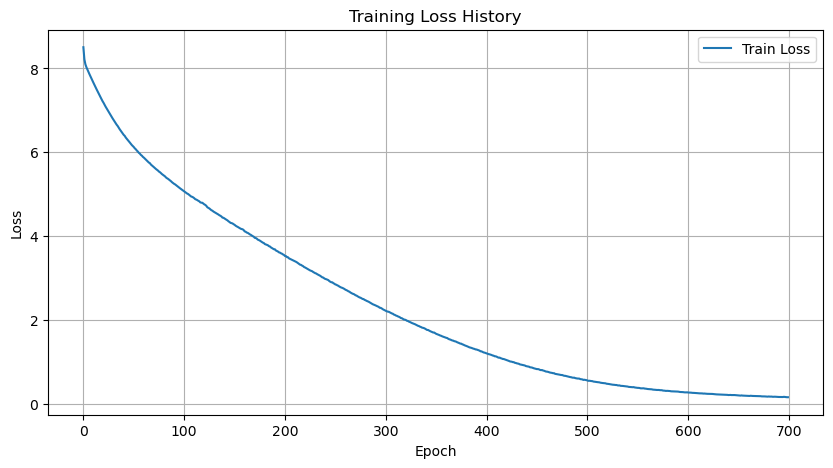

In [25]:
import matplotlib.pyplot as plt

# Plotting the loss history
plt.figure(figsize=(10, 5))
plt.plot(history_loss, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.legend()
plt.grid(True)
plt.show()


In [19]:

# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


vocab_qc_inv = {v: k for k, v in vocab_qc.items()}
# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    tokenized_sentence =  list(tgt_tokens.cpu().numpy())
    sentence = ' '.join(vocab_qc_inv[i] for i in tokenized_sentence)
    return sentence.replace('<bos>', '').replace('<eos>', '')
    

In [30]:
torch.save(transformer,"./models/v1_transformer_translator_finetuned.pth")


In [20]:
model = torch.load("./models/v1_transformer_translator_finetuned.pth")

/tmp/ipykernel_4268/358670441.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("./models/v1_transformer_translator_finetuned.pth")


In [25]:
translate(model, "persona")

' runa '

In [27]:
dataset['model_translation'] = dataset['sp'].apply(lambda x: translate(model,x))

In [51]:
import sacrebleu 
sacrebleu.sentence_bleu('hola como estas tu', ['hola como estas tu'],smooth_method='exp').score

100.00000000000004

In [56]:


# Helper function to calculate BLEU score for a pair of sentences
def calculate_bleu(reference, candidate):
    return sacrebleu.sentence_bleu(reference, [candidate]).score

# Apply the BLEU score calculation to your dataset
dataset['bleu_score'] = dataset.apply(lambda x: calculate_bleu(x['qc'], x['model_translation']), axis=1)
dataset['bleu_score']

0     100.000000
1     100.000000
2     100.000000
3     100.000000
4     100.000000
         ...    
95      5.140708
96     22.506761
97     26.934666
98      8.345883
99      4.648491
Name: bleu_score, Length: 2169, dtype: float64

In [61]:
global_bleu_score = dataset['bleu_score'].mean()
global_bleu_score

93.40952034887258

In [31]:
from fastapi import FastAPI

app = FastAPI()

@app.get("/")
def read_root():
    return {"Hello": "World"}

@app.get("/translate/")
def read_item(text: str):
    return {"translation": translate(model, preprocess_sentence(text))}

In [32]:
import uvicorn
from threading import Thread

def run():
    uvicorn.run(app, host="0.0.0.0", port=8000)

server = Thread(target=run)
server.start()

INFO:     Started server process [34020]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
ERROR:    [Errno 98] error while attempting to bind on address ('0.0.0.0', 8000): address already in use
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.


vamos a jugar
INFO:     10.240.1.166:0 - "GET /translate/?text=vamos%20a%20jugar HTTP/1.1" 200 OK


In [44]:
preprocess_sentence("La receta de Cheesecake de Frutos del Bosque es: 1.  Mezclar las galletas molidas con la mantequilla derretida hasta obtener una masa compacta. Colocar en un molde para cheesecake y presionar hacia el fondo del molde hasta que quede parejo. Congelar por 20 minutos. 2.  Para el relleno: 3.  En un recipiente, batir el queso crema con la leche condensada Nestlé hasta homogenizar. Añadir los huevos, uno por uno, y seguir batiendo hasta que la mezcla quede uniforme. 4.  Integrar mezclando con cuidado las moras y las frambuesas. 5.  Verter la preparación en el molde con la base de galletas. Llevar al horno 180°C a baño María durante 1 hora aproximadamente. Para saber si ya está listo, insertar un palito, el cual debe quedar limpio al momento de salir.")

'la receta de cheesecake de frutos del bosque es mezclar las galletas molidas con la mantequilla derretida hasta obtener una masa compacta colocar en un molde para cheesecakepresionar hacia el fondo del molde hasta que quede parejo congelar por minutos para el relleno en un recipiente batir el queso crema con la leche condensada nestlé hasta homogenizar añadir los huevos uno por uno seguir batiendo hasta que la mezcla quede uniforme integrar mezclando con cuidado las moraslas frambuesas verter la preparación en el molde con la base de galletas llevar al horno °cbaño maría durantehora aproximadamente para saber si ya está listo insertar un palito el cual debe quedar limpio al momento de salir'